In [7]:
import os
from glob import glob
import argparse

import torch
import lightning.pytorch as pl
os.chdir('/auto/k2/bguven/sar_image/BraDD-S1TS')
import source as src


def create_folder(*names) -> str:
    path = os.path.join(*names)
    if not os.path.exists(path):
        os.mkdir(path)

    return path


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--Storing_experimentName', type=str, default='Default')
    parser.add_argument('--Storing_wandbProject', type=str)
    # For not using W&B, use '--Storing_wandbProject None' ==> None in str
    parser.add_argument('--Storing_wandbEntity', type=str)
    parser.add_argument('--Storing_wandbTags', type=str, nargs='+', default=['Default'])
    parser.add_argument('--Storing_savingPath', type=str)
    parser.add_argument('--Storing_useTqdm', type=bool, default=True)

    parser.add_argument('--DataModule_Dataset_Normalization_method', type=str, default='ZScore')
    parser.add_argument('--DataModule_Dataset_numCpu', type=int, default=8)
    parser.add_argument('--DataModule_Dataset_TemporalDropout_isRandom', type=bool, default=False)
    parser.add_argument('--DataModule_Dataset_TemporalDropout_numTemporal', type=int, default=-1)
    # NOTE: if num_temporal < 0 ==> No temporal dropout!
    # NOTE: if num_temporal > {a big number} and isRandom == True  ==> Shuffling the image dates.
    parser.add_argument('--DataModule_Dataset_path', type=str)
    parser.add_argument('--DataModule_Dataset_split', type=str, default='test')
    parser.add_argument('--DataModule_batchSize', type=int, default=4)  # 8 with UTAE ==> GPU: 9 GB

    parser.add_argument('--Experiment_learningRate', type=float, default=1e-3)
    parser.add_argument('--Experiment_weightDecay', type=float, default=0.0)
    parser.add_argument('--Experiment_patienceEpoch', type=int, default=10)
    parser.add_argument('--Experiment_saveOutputs', type=bool, default=True)

    parser.add_argument('--Network_forwardType', type=str, default='segment')
    parser.add_argument('--Network_architecture', type=str, default='UTAE')
    parser.add_argument('--Network_Model_out_conv', type=int, nargs='+', default=[32, 2])
    # NOTE: Last Channel = {num_class} for multi-class problem or 2 for default (Binary Problem)

    parser.add_argument('--Loss_name', type=str, default='CrossEntropy')
    # parser.add_argument('--Loss_LossHyperparameters_...', type=str)  # ==> Use for hyperparameter sweeping

    parser.add_argument('--Score_numClass', type=int, default=2)  # 2 For binary problem
    parser.add_argument('--Score_evalScores', type=bool, default=True)
    parser.add_argument('--Score_runningScores', type=bool, default=False)

    parser.add_argument('--ForwardFunction_mode', type=str, default='ChangeDetection')
    parser.add_argument('--selGPU', type=int, default="2")

    args = vars(parser.parse_args(['--Storing_wandbProject', 'BraDD-S1TS_SAR',
                                      '--Storing_wandbEntity', 'btrgvn',
                                      '--Storing_savingPath', '/auto/k2/bguven/sar_image/BraDD-S1TS/experiments',
                                      '--DataModule_Dataset_path', '/auto/k2/bguven/sar_image/BraDD-S1TS_zenodo',
                                      '--selGPU', '2'
                                   

    ]))

    # select the gpu
    os.environ["CUDA_VISIBLE_DEVICES"] = "{}".format(args['selGPU'])
    
    # Creating saving folders
    exp_path = create_folder(args['Storing_savingPath'])
    exp_path = create_folder(exp_path, args['Storing_wandbProject'])
    exp_path = create_folder(exp_path, args['Storing_experimentName'])

    # Creating the objects
    torch.set_float32_matmul_precision('medium')
    pl.seed_everything(42, workers=True)


    trainer = pl.Trainer(
        default_root_dir=exp_path,
        enable_progress_bar=args['Storing_useTqdm'],

        # Fixed limits
        max_epochs=200,  # Default: 200
        max_time={'days': 6, 'hours': 23},

        # Debugging
        detect_anomaly=False,  # True for debugging | False for fast run
        deterministic=False,  # True for Reproducibility | False for fast run
        num_sanity_val_steps=0,  # 0 for standard run | -1 for checking all validation set | 2 for debug
        # overfit_batches=5,  # Default = 0
        # profiler='advanced',
    )


    network = src.Network(**src.get_args(args, 'Network'))
    loss = src.LossFunction(**src.get_args(args, 'Loss'))
    score = {k: src.SegmentationScores(**src.get_args(args, 'Score')) for k in ['Train', 'Validation', 'Test']}
    forward_function = src.ForwardFunction(**src.get_args(args, 'ForwardFunction'))
    experiment = src.Experiment(
        network=network,
        loss=loss,
        score=score,
        forwardFunction=forward_function,
        savingFolder=os.path.join(exp_path, 'Samples') if args['Experiment_saveOutputs'] else None,
        **src.get_args(args, 'Experiment'),
    )

    # Training
    # trainer.fit(model=experiment, datamodule=data_module)
    data_module = src.MultiEarthDataModule(**src.get_args(args, 'DataModule'))
    # Testing
    model_paths = glob(os.path.join(exp_path, 'checkpoints', '*.ckpt'))
    model_paths.sort()
    best_model_path = model_paths[-1]  # One with the best score --> Check naming of the models
    trainer.test(model=experiment, datamodule=data_module, ckpt_path=best_model_path)

    print('EOF')


Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/auto/k2/bguven/miniconda3/envs/cGAN_env/lib/python3.9/multiprocessing/queues.py", line 239, in _feed
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/auto/k2/bguven/miniconda3/envs/cGAN_env/lib/python3.9/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/auto/k2/bguven/miniconda3/envs/cGAN_env/lib/python3.9/multiprocessing/connection.py", line 177, in close
    reader_close()
  File "/auto/k2/bguven/miniconda3/envs/cGAN_env/lib/python3.9/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/auto/k2/bguven/miniconda3/envs/cGAN_env/lib/python3.9/multiprocessing/connection.py", line 361, in _close
    self._close()
  File "/auto/k2/bguven/miniconda3/envs/cGAN_env

KeyError: 'test_set'

In [ ]:
import os
from glob import glob
import argparse

import torch
import lightning.pytorch as pl
os.chdir('/auto/k2/bguven/sar_image/BraDD-S1TS')
import source as src


def create_folder(*names) -> str:
    path = os.path.join(*names)
    if not os.path.exists(path):
        os.mkdir(path)

    return path


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--Storing_experimentName', type=str, default='Default')
    parser.add_argument('--Storing_wandbProject', type=str)
    # For not using W&B, use '--Storing_wandbProject None' ==> None in str
    parser.add_argument('--Storing_wandbEntity', type=str)
    parser.add_argument('--Storing_wandbTags', type=str, nargs='+', default=['Default'])
    parser.add_argument('--Storing_savingPath', type=str)
    parser.add_argument('--Storing_useTqdm', type=bool, default=True)

    parser.add_argument('--DataModule_Dataset_Normalization_method', type=str, default='ZScore')
    parser.add_argument('--DataModule_Dataset_numCpu', type=int, default=8)
    parser.add_argument('--DataModule_Dataset_TemporalDropout_isRandom', type=bool, default=False)
    parser.add_argument('--DataModule_Dataset_TemporalDropout_numTemporal', type=int, default=-1)
    # NOTE: if num_temporal < 0 ==> No temporal dropout!
    # NOTE: if num_temporal > {a big number} and isRandom == True  ==> Shuffling the image dates.
    parser.add_argument('--DataModule_Dataset_path', type=str)
    parser.add_argument('--DataModule_Dataset_split', type=str, default='close')
    parser.add_argument('--DataModule_batchSize', type=int, default=4)  # 8 with UTAE ==> GPU: 9 GB

    parser.add_argument('--Experiment_learningRate', type=float, default=1e-3)
    parser.add_argument('--Experiment_weightDecay', type=float, default=0.0)
    parser.add_argument('--Experiment_patienceEpoch', type=int, default=10)
    parser.add_argument('--Experiment_saveOutputs', type=bool, default=True)

    parser.add_argument('--Network_forwardType', type=str, default='segment')
    parser.add_argument('--Network_architecture', type=str, default='UTAE')
    parser.add_argument('--Network_Model_out_conv', type=int, nargs='+', default=[32, 2])
    # NOTE: Last Channel = {num_class} for multi-class problem or 2 for default (Binary Problem)

    parser.add_argument('--Loss_name', type=str, default='CrossEntropy')
    # parser.add_argument('--Loss_LossHyperparameters_...', type=str)  # ==> Use for hyperparameter sweeping

    parser.add_argument('--Score_numClass', type=int, default=2)  # 2 For binary problem
    parser.add_argument('--Score_evalScores', type=bool, default=True)
    parser.add_argument('--Score_runningScores', type=bool, default=False)

    parser.add_argument('--ForwardFunction_mode', type=str, default='ChangeDetection')
    parser.add_argument('--selGPU', type=int, default="2")

    args = vars(parser.parse_args(['--Storing_wandbProject', 'BraDD-S1TS_SAR',
                                      '--Storing_wandbEntity', 'btrgvn',
                                      '--Storing_savingPath', '/auto/k2/bguven/sar_image/BraDD-S1TS/experiments',
                                      '--DataModule_Dataset_path', '/auto/k2/bguven/sar_image/BraDD-S1TS_zenodo',
                                      '--selGPU', '2'
                                   

    ]))

    # select the gpu
    os.environ["CUDA_VISIBLE_DEVICES"] = "{}".format(args['selGPU'])
    
    # Creating saving folders
    exp_path = create_folder(args['Storing_savingPath'])
    exp_path = create_folder(exp_path, args['Storing_wandbProject'])
    exp_path = create_folder(exp_path, args['Storing_experimentName'])

    # Creating the objects
    torch.set_float32_matmul_precision('medium')
    pl.seed_everything(42, workers=True)


    trainer = pl.Trainer(
        default_root_dir=exp_path,
        enable_progress_bar=args['Storing_useTqdm'],

        # Fixed limits
        max_epochs=200,  # Default: 200
        max_time={'days': 6, 'hours': 23},

        # Debugging
        detect_anomaly=False,  # True for debugging | False for fast run
        deterministic=False,  # True for Reproducibility | False for fast run
        num_sanity_val_steps=0,  # 0 for standard run | -1 for checking all validation set | 2 for debug
        # overfit_batches=5,  # Default = 0
        # profiler='advanced',
    )


    network = src.Network(**src.get_args(args, 'Network'))
    loss = src.LossFunction(**src.get_args(args, 'Loss'))
    score = {k: src.SegmentationScores(**src.get_args(args, 'Score')) for k in ['Train', 'Validation', 'Test']}
    forward_function = src.ForwardFunction(**src.get_args(args, 'ForwardFunction'))
    experiment = src.Experiment(
        network=network,
        loss=loss,
        score=score,
        forwardFunction=forward_function,
        savingFolder=os.path.join(exp_path, 'Samples') if args['Experiment_saveOutputs'] else None,
        **src.get_args(args, 'Experiment'),
    )

    # Training
    # trainer.fit(model=experiment, datamodule=data_module)
    data_module = src.MultiEarthDataModule(**src.get_args(args, 'DataModule'))
    # Testing
    model_paths = glob(os.path.join(exp_path, 'checkpoints', '*.ckpt'))
    model_paths.sort()
    best_model_path = model_paths[-1]  # One with the best score --> Check naming of the models
    trainer.test(model=experiment, datamodule=data_module, ckpt_path=best_model_path)

    print('EOF')


In [7]:
import torch
data = torch.load('/auto/k2/bguven/sar_image/BraDD-S1TS_zenodo/real_time/first_data.pt')
data.keys()

dict_keys(['image_dates', 'image'])

In [8]:
data['image_dates']

[datetime.date(2020, 7, 1),
 datetime.date(2020, 7, 1),
 datetime.date(2020, 8, 1),
 datetime.date(2020, 9, 1),
 datetime.date(2020, 10, 1),
 datetime.date(2020, 11, 1),
 datetime.date(2020, 12, 1),
 datetime.date(2021, 1, 1),
 datetime.date(2021, 2, 1),
 datetime.date(2021, 3, 1),
 datetime.date(2021, 4, 1),
 datetime.date(2021, 5, 1),
 datetime.date(2021, 6, 1),
 datetime.date(2021, 7, 1),
 datetime.date(2021, 8, 1),
 datetime.date(2021, 9, 1),
 datetime.date(2021, 10, 1),
 datetime.date(2021, 11, 1)]

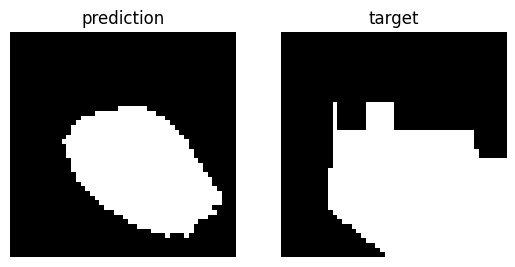

In [34]:
import matplotlib.pyplot as plt
data_my = torch.load('/auto/k2/bguven/sar_image/BraDD-S1TS/experiments/BraDD-S1TS_SAR/Default/Samples/0000010.pt')
for i,label in enumerate(data_my):
    plt.subplot(1,2,i+1)
    plt.imshow(data_my[label].squeeze(),cmap='gray')
    plt.title(label)
    plt.axis("off")
plt.savefig('sample.png')
plt.show()
plt.close()
